<center>
    
# Monte Carlo: Modelling  Photon Paths in Water
    
</center>

# Introduction
The presented Python code utilises Monte Carlo simulations to model the trajectories of photons interacting with water based on their energy. Monte Carlo methods are powerful tools in physics for stochastic modelling, and in this context, they are applied to emulate the intricate interactions between photons and water. The simulation accounts for various interaction processes such as Compton scattering, the photoelectric effect, and pair production, which collectively contribute to the attenuation of photons in the travelling medium.

## For Whom Is This Repository Targeted?
This repository serves as a comprehensive resource designed to provide insight into the intricate interactions between photons and matter, along with an introduction to the principles of Monte Carlo simulations. Tailored for both students and professors, the content aims to facilitate a profound understanding of these phenomena and simulation techniques. Whether you're an aspiring learner or an educator seeking illustrative materials for classroom use, this repository offers valuable insights and practical examples.

# Outline:
- [ 0 - Simulated Photon Energies ](#0)
- [ 1 - Photon Interactions ](#1)
    - [ 1.1 Photoelectric Effect](#1.1)
    - [ 1.2 Compton Scattering](#1.2)
    - [ 1.3 Pair Production](#1.3)
- [ 2 -  Photon Attenuation ](#2)
    - [ 2.1 Attenuation Coefficient and Interaction Cross Section](#2.1)
- [ 3 - Interaction Probability](#3)
- [ 4 - Sampling Photon Steplenghts](#4)
    - [ 4.1 - Depth Probability Distributions](#4.1)
    - [ 4.2 - MC Inverse Transform Method](#4.2)
- [ 5 - Scattered Photon Energy Calculation](#5)
- [ 6 - Sampling Compton Scattering Angles](#6)
    - [ 6.1 - Normalised Differential cross-section](#6.1)
    - [ 6.2 - MC Rejection sampling](#6.2)
- [ 7 - Photon Path Simulation](#7)
    - [ 7.1 Frame of Reference Transformation](#7.1)
    - [ 7.2 Simulating Photon Paths in a Medium](#7.2)
- [ 8 Conclusion and Visualisations](#8)
    - [ 8.1 High vs. Low-Energy Photon Paths](#8.1)
    - [ 8.2 Visual Representation: Energy Contrast](#8.2)
    - [ 8.3 Evolution of 2 MeV Photons: Attenuation and Scattering](#8.3)


In [155]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as scp
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import math
from math import pi
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

<a name="0"></a>
# 0. Simulated Photon Energies
In this simulation, we'll focus on two photon energies, namely 50keV and 2MeV. These specific energies have been selected because they encompass all three photon interactions discussed. Additionally, they accentuate the variations in photon trajectories based on energy. 
<br>
You have the flexibility to modify these energies within the range of 0 to 20 MeV as per your preference. However make sure to adjust the simulation parameters accordingly based on the photon energy to avoid any complications.

In [156]:
## Photon energies are inputed as MeV
photon_energy_1 = 0.05
photon_energy_2 = 2

<a name="1"></a>
# 1. Photon Interactions
### Fundamental  Constants and Functions:
The code begins by defining fundamental  constants related to the Compton scattering, photoelectric effect, and pair production processes. These constants include the rest mass of an electron, the number of electrons per unit volume in water, the classical electron radius, the fine-structure constant, and the atomic number of water. These constants serve as crucial parameters for calculating cross-sections and interaction probabilities.

In [157]:
## Useful Constants ##
moc2 = 0.510998955 # Rest mass of electron in MeV
n_v = 3.43*1e+22 # Number of electrons per unit volume in water cm-3
re = 2.81794 * 1e-13  # Classical electron radius in cm
alpha = 1 / 137  # Fine-structure constant
Z = 10  # Approximate atomic number for water (H₂O)

<a name="1.1"></a>
## 1.1 Photoelectric Effect
The photoelectric effect is a phenomenon theorised by Albert Einstein, where the incident photon is absorbed by the atom and results in excitation or ionisation based on the incident photon’s energy. For the purpose of simulating photon paths however, we are only interested at the fact that the photon is removed from the beam path if it interacts by the photoelectric effect. 
<br/>
The cross-section for the photoelectric effect can be calculated using the formula:

$$
\begin{equation}
\sigma_{\text{ph}} = \frac{16}{2} \sqrt{2}\pi r_{e}^2 \alpha^4 \left(\frac{Z^5}{k^{3.5}}\right)\label{eq1}\tag{1}
\end{equation}
$$

where $r_{e}$ is the classical electron radius, $α$ is the fine-structure constant, $Z$ is the atomic number of the material, and $k$ is the ratio of the photon energy to the electron rest mass energy. The equation above demonstrates the complex relationship of the cross section and various factors. However, it is notable that the cross section is primarily influenced by two key factors, the atomic number $Z$ raised to the power of 5 and the inverse cubed photon energy $1/(hv)^3$. The $Z^5$ dependence highlights that interactions are more likely to occur with heavier target nuclei that possess a greater number of electrons available for excitation. Furthermore, the cross section decreases as the photon energy increases, indicating that the photoelectric effect becomes more relevant for low-energy photons.


In [158]:
## Function to calculate photoelectric effect cross-section ##
def sigma_ph(en):
    a = en/moc2
    return (16 / 2) * np.sqrt(2) * np.pi * (re ** 2) * (alpha ** 4) * ((Z ** 5) / (a ** 3.5))

<a name="1.2"></a>
## 1.2 Compton Scattering 

Compton scattering is a fundamental process in which photons interact with charged particles, typically electrons, leading to a change in the photon's direction and a transfer of energy to the electron. This phenomenon, discovered by Arthur H. Compton, is a crucial component in understanding the behavior of X-rays and gamma rays as they traverse matter. The Compton scattering cross-section $σ$ quantifies the likelihood of this scattering event occurring and is defined by the Klein-Nishina equation:

$$
\sigma_{\text{c}} = 2\pi Z r_{e}^2 \left\{\frac{(1+k)}{k^2} \left[\frac{2(1+k)}{1+2k} - \frac{\ln(1+2k)}{k}\right] + \frac{\ln(1+2k)}{2k} - \frac{1+3k}{(1+2k)^2}\right\} \label{eq2}\tag{2}  ,
$$

where $k$ is defined as $ k = hv / m_ec^2 $ with $hv$ being the photon energy and $m_ec^2$ the electron rest mass. 
This equation describes the probability of a photon undergoing Compton scattering within a medium, with the cross-section depending on the incident photon energy. From this we can infer that the dominant photon interaction as the incident photon energy increases transits from the photoelectric effect to Compton scattering. Additionally, the probability of interaction depends on the electron density of the target where more loosely bound electrons are present.


In [159]:
## Function to calculate Compton scattering cross-section ##
def sigma(en):
  a = en/moc2
  t1 = ((1+a)/a**2)*(((2*(1+a)/(1+2*a)) - np.log(1 + 2*a)/a))
  t2 = np.log(1+2*a)/ (2*a)
  t3 = (1+3*a)/((1+2*a)**2)
  t= (t1+t2-t3)
  return 2*Z*np.pi*((re**2)) * t

<a name="1.3"></a>
## 1.3 Pair Production

Pair production represents a significant phenomenon where a high-energy photon undergoes absorption within the nuclear electromagnetic field of an atom, leading to the generation of an electron-positron pair. This intricate process necessitates the incident photon’s energy to exceed twice the rest mass energy of the electron, approximately 1.022 MeV, to facilitate the interaction

The determination of the total cross section for pair production is complex and often approximated through theoretical models. It encompasses various factors such as the properties of the target material, the energy of the incident photons, and quantum electrodynamics principles.The atomic cross section of pair production can be approximated by,

$$
k \approx a r_0^2 Z^2 \overline{P} \label{eq3}\tag{3}
$$

By inspection of equation (\ref{eq3}), it can be inferred that the atomic cross section for pair production is proportional to the square of the atomic number and the energy of the incident photon. This relationship implies that pair production becomes increasingly significant for high-energy photons and in materials with higher atomic numbers.
For the purpose of this simulation we are going to approximate the pair production cross section from tabulated valious and utilise polynomila reggresion to estimate the cross-section within an energy range.


In [160]:
data = {
    'Energy (energyMev)': [0.0001, 0.00015, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0015, 0.002, 0.003, 0.004, 0.005, 0.006, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.66163, 0.8, 1, 1.1732, 1.2522, 1.3325, 1.5, 2, 3, 4, 5, 6, 8, 10, 15, 20],
    'Hydrogen cs': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.70E-29, 8.03E-29, 1.67E-28, 4.43E-28, 1.78E-27, 5.11E-27, 8.30E-27, 1.11E-26, 1.37E-26, 1.79E-26, 2.14E-26, 2.79E-26, 3.28E-26],
    'Oxygen cs': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.80E-27, 5.29E-27, 1.09E-26, 2.87E-26, 1.14E-25, 3.33E-25, 5.31E-25, 7.12E-25, 8.71E-25, 1.14E-24, 1.36E-24, 1.78E-24, 2.08E-24]
}
df = pd.DataFrame(data)
print(df.tail())

# Calculate weighted average and create a new dataframe
weighted_average = (df['Hydrogen cs'] * 2 + df['Oxygen cs']) / 3
df_w = pd.DataFrame({'energyMev': df['Energy (energyMev)'], 'cs': weighted_average})
#print(df_w)

    Energy (energyMev)   Hydrogen cs     Oxygen cs
42                 6.0  1.370000e-26  8.710000e-25
43                 8.0  1.790000e-26  1.140000e-24
44                10.0  2.140000e-26  1.360000e-24
45                15.0  2.790000e-26  1.780000e-24
46                20.0  3.280000e-26  2.080000e-24


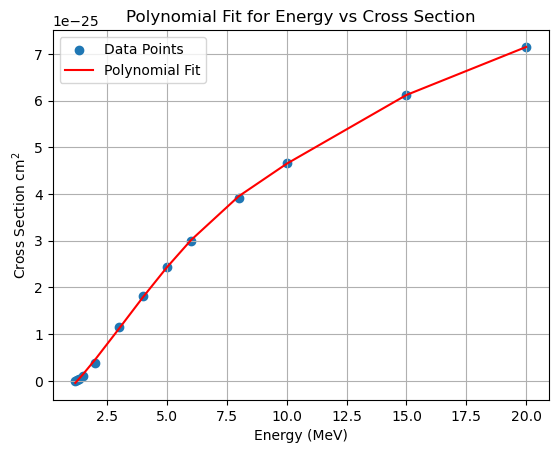

In [161]:
## Polynomial Regression ##
filtered_df = df_w[(df_w['energyMev'] > 1) & (df_w['cs'] != 0)] # remove 0 values
# Extracting the variables for regression
X = filtered_df['energyMev'].values.reshape(-1, 1)  # Independent variable (features)
y = filtered_df['cs'].values  # Dependent variable (target)
# Generating polynomial features
poly = PolynomialFeatures(degree=5)  # You can change the degree of the polynomial
X_poly = poly.fit_transform(X)
# Creating a Polynomial Regression model
model = LinearRegression()
# Fitting the model
model.fit(X_poly, y)
# Predicting on the fitted model
y_pred = model.predict(X_poly)
# Get the coefficients of the fitted polynomial
coefficients = model.coef_
intercept = model.intercept_

# Define a function to calculate predicted cross-section based on energy
def sigma_pair_production(energy):
    # Transform the input energy to polynomial features
    energy_poly = poly.transform(np.array([[energy]]))
    # Calculate the predicted cross-section using the coefficients and polynomial features
    predicted_cs = np.dot(energy_poly, coefficients.T) + intercept
    # Ensure non-negativity
    if predicted_cs < 0:
        return 0
    if energy < 1.022: #Implement energy requirement
        predicted_cs = 0
    return float(predicted_cs)


# Plotting data points and the polynomial curve
plt.scatter(X, y, label='Data Points')
plt.plot(X, y_pred, color='red', label='Polynomial Fit')
plt.xlabel('Energy (MeV)')
plt.ylabel('Cross Section cm$^{2}$')
plt.title('Polynomial Fit for Energy vs Cross Section')
plt.legend()
plt.grid(True)
plt.show()

<a name="2"></a>
# 2. Photon Attenuation 

Photon attenuation, which indicates the reduction in the intensity of a photon beam as it traverses through matter, plays a fundamental role in simulating photon paths. The attenuation is quantified by the linear attenuation coefficient $μ$, which represents the probability of interaction per unit length. 
As mentioned above, the probability for a single interaction is quantified through the interaction cross section. Therefore, the attenuation coefficient is the combination of all the partial interaction processes and is characterised as,
$$
\mu = (\sigma_p + \sigma_c + \sigma_P) \cdot n_v \label{eq4}\tag{4}
$$

Where $n_v$  is the number of electrons per unit volume in water, and $σ_i$ is the cross section for the aforementioned photon interactions. The principal interaction is thus dependent on the ratio of the cross sections and is affected by photon energy in our case.


In [162]:
# Define energy range
energies = np.arange(0, 20,0.001) # We simulate up to 20MeV photons 

# Calculate cross-sections for each energy for photoelectric effect, Compton scattering and Pair Production 
cross_sections_ph = np.array([sigma_ph(energy) for energy in energies])
cross_sections_cs = np.array([sigma(energy) for energy in energies])
cross_sections_pp = np.array([sigma_pair_production(energy) for energy in energies])

# Convert cross-sections to attenuation coefficients
attenuation_ph = np.array(cross_sections_ph) * n_v
attenuation_cs = np.array(cross_sections_cs) * n_v
attenuation_pp = cross_sections_pp * n_v

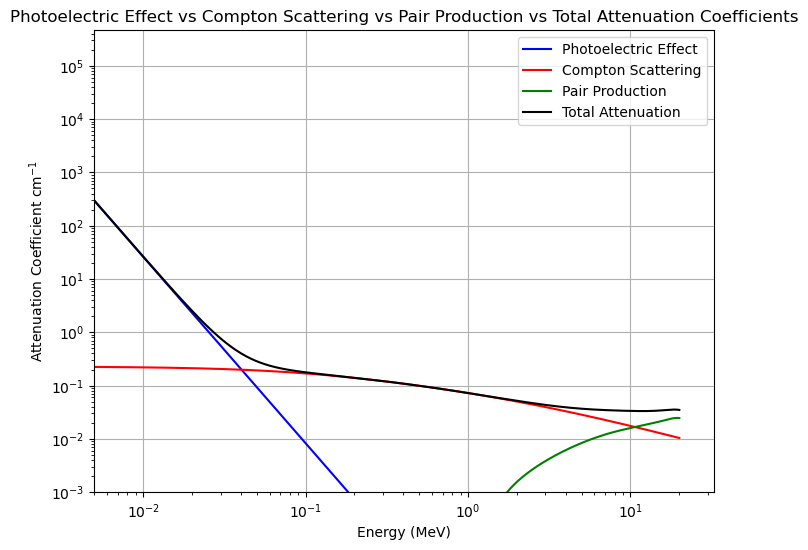

In [163]:
# Calculate the total attenuation coefficient
total_attenuation = attenuation_ph + attenuation_cs + attenuation_pp
# Plotting photoelectric effect, Compton scattering, pair production, and total attenuation coefficients against energy (log-log scale)
plt.figure(figsize=(8, 6))
plt.plot(energies, attenuation_ph, label='Photoelectric Effect', color='blue')
plt.plot(energies, attenuation_cs, label='Compton Scattering', color='red')
plt.plot(energies, attenuation_pp, label='Pair Production', color='green')
plt.plot(energies, total_attenuation, label='Total Attenuation', color='black')  # Adding Total Attenuation
plt.xlabel('Energy (MeV)')
plt.ylabel('Attenuation Coefficient cm$^{-1}$')
plt.title('Photoelectric Effect vs Compton Scattering vs Pair Production vs Total Attenuation Coefficients')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim(0.001)
plt.xlim(0.005)
plt.show()

<a name="2.1"></a>
## 2.1 Attenuation Coefficient and Interaction Cross Section


The follwing function serves a crucial role in simulating a photon beam travers through a medium. By taking the photon energy as an input, the function calculates the cross-sections for photoelectric effect, Compton scattering, and pair production, representing the probabilities of these interactions. Subsequently, these cross-sections are converted into respective attenuations per unit length by multiplying with the number of electrons per unit volume $n_v$, as descriped by equation 4.
<br/>
The function then computes the total attenuation coefficient by summing the individual attenuations. This total attenuation coefficient quantifies the overall reduction in the intensity of the photon beam, incorporating the collective effects of all interaction processes. Therefore, the function provides valuable information into both the attenuation and the probability of interaction per unit length for each of the three photon interactions, aiding in the comprehensive analysis of photon paths through the medium.

In [164]:
def total_attenuation_coefficient(energy):
    # Calculate cross-sections for photoelectric effect, Compton scattering, pair production, etc.
    cross_section_ph = sigma_ph(energy)
    cross_section_cs = sigma(energy)
    cross_section_pair_production = sigma_pair_production(energy)
    
    # Convert cross-sections to respective attenuations
    attenuation_ph = cross_section_ph * n_v
    attenuation_cs = cross_section_cs * n_v
    attenuation_pair_production = cross_section_pair_production * n_v
    
    # Calculate total attenuation coefficient by summing all attenuations
    total_attenuation = attenuation_ph + attenuation_cs + attenuation_pair_production
    
    return (total_attenuation, attenuation_ph, attenuation_cs, attenuation_pair_production)


In [165]:
#Attenuation for photon energy 1 
b_1 = total_attenuation_coefficient(photon_energy_1)
print((f"For photon energy {photon_energy_1} MeV, the Total Attenuation Coefficient is {b_1[0]:.3f} , the PE Attenuation is {b_1[1]:.3f} the Compton Attenuation is {b_1[2]:.3f} and the Pair Production Attenuation is {b_1[3]:.3f} "))
m_1 = b_1[0]
cs_1 = b_1[2]
           
#Attenuation for photon energy 2
b_2 = total_attenuation_coefficient(photon_energy_2)
print((f"For photon energy {photon_energy_2} MeV, the Total Attenuation Coefficient is {b_2[0]:.3f} , the PE Attenuation is {b_2[1]:.3f} the Compton Attenuation is {b_2[2]:.3f} and the Pair Production Attenuation is {b_2[3]:.3f} "))
m_2 = b_2[0]
cs_2 = b_2[2]



For photon energy 0.05 MeV, the Total Attenuation Coefficient is 0.286 , the PE Attenuation is 0.094 the Compton Attenuation is 0.193 and the Pair Production Attenuation is 0.000 
For photon energy 2 MeV, the Total Attenuation Coefficient is 0.052 , the PE Attenuation is 0.000 the Compton Attenuation is 0.050 and the Pair Production Attenuation is 0.002 


<a name="3"></a>
# 3. Interaction Probability

In the Interaction Probability section, we explore how the probability of each photon interaction varies with energy. The interaction probabilities are calculated by normalising the cross sections for photoelectric effect, Compton scattering, and pair production with respect to the total cross section. This normalisation allows us to determine the likelihood of each interaction process occurring for photons with specific energies. By examining the ratios of these cross sections, we gain insights into the dominant interaction mechanism at different energy levels. The accompanying bar graphs illustrate how these probabilities change at two distinct photon energy values (50 keV and 2 MeV), providing a visual representation of the relative significance of each interaction type at different energy regimes.
<br/>
Please keep in mind that this function DOES NOT estimate the probability of interaction, but the probability of what interaction will take place if the photon interacts with the medium at a specific energy.


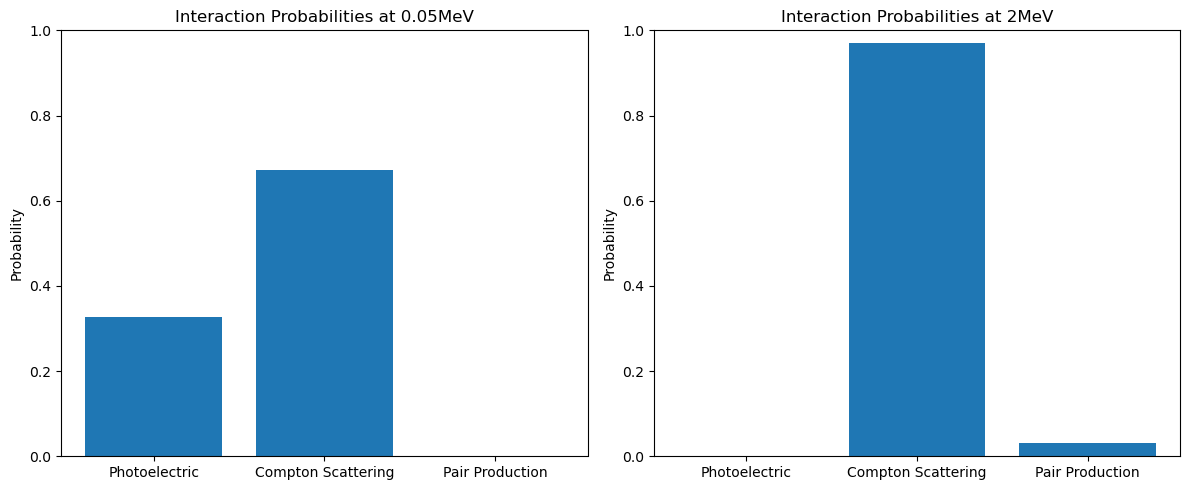

In [166]:
# Function to calculate interaction probabilities for a given photon energy
def calculate_interaction_probabilities(photon_energy):
    cross_section_ph = sigma_ph(photon_energy) *n_v
    cross_section_cs = sigma(photon_energy)*n_v
    cross_section_pp = sigma_pair_production(photon_energy)*n_v
    total_cross_section = cross_section_ph + cross_section_cs + cross_section_pp
    # Normalize probabilities
    probability_ph = cross_section_ph / total_cross_section
    probability_cs = cross_section_cs / total_cross_section
    probability_pp = cross_section_pp / total_cross_section
    normalized_probabilities = [probability_ph , probability_cs, probability_pp ]
    return normalized_probabilities


# Define photon energies
photon_energies = [photon_energy_1, photon_energy_2]
# Create dictionaries to store data frames for each energy
data_frames = {}
for energy in photon_energies:
    normalized_probabilities = calculate_interaction_probabilities(energy)
    # Create DataFrame for each energy without normalization
    data = {
        'Interaction Probability': normalized_probabilities,
        'Interaction': ['Photoelectric', 'Compton Scattering', 'Pair Production']
    }
    df = pd.DataFrame(data)
    if energy == photon_energy_1:
        df1 = df  # Save data frame for photon energy 1 
    elif energy == photon_energy_2:
        df2 = df  # Save data frame for photon energy 2
# Create subplots for bar graphs
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting bar graphs for interaction probabilities at photon energies 1 & 2
axs[0].bar(df1['Interaction'], df1['Interaction Probability'])
axs[0].set_title(f'Interaction Probabilities at {photon_energy_1}MeV')
axs[0].set_ylabel('Probability')
axs[0].set_ylim(0, 1)
axs[1].bar(df2['Interaction'], df2['Interaction Probability'])
axs[1].set_title(f'Interaction Probabilities at {photon_energy_2}MeV')
axs[1].set_ylabel('Probability')
axs[1].set_ylim(0, 1)
plt.tight_layout()
plt.show()


<a name="4"></a>
# 4. Sampling Photon Steplenghts

<a name="4.1"></a>
# 4.1 Depth Probability Distributions

## Probability Distribution Function (PDF) and Cumulative Distribution Function (CDF)
In the context of simulating the depth of interaction, the Probability Distribution Function (PDF) and Cumulative Distribution Function (CDF) play crucial roles.

### Probability Distribution Function (PDF)
The Probability Distribution Function, denoted as $P(x)$, represents the probability of a photon interacting at a certain depth $x$. Mathematically, it is expressed by the formula:
$$
 P(x) = e^{-x\mu} \, \label{eq5}\tag{5}
$$

where $\mu$ is the attenuation coefficient and $x$ is the depth of interaction. To ensure that the probabilities are normalised, the integral of the PDF over all possible depths must equal 1, as shown in the normalisation equation:
$$
 \int_{0}^{\infty} P(x) \, dx = 1 \ \label{eq6}\tag{6}
$$
The normalised probability, serving as the PDF of photon interactions, is then defined as:
$$
 P(x) = \frac{1}{\mu} e^{-x\mu} \, \label{eq7}\tag{7}
$$

### Cumulative Distribution Function (CDF)
The Cumulative Distribution Function, abbreviated as CDF, is derived from the cumulative sum of the PDF. It is defined as:
$$
CDF = 1 - e^{-x\mu}
$$
The CDF is a continuously increasing function, starting at **0** for the minimum depth $x_{min}$ and reaching **1** for the maximum depth $x_{max}$. It provides a cumulative probability distribution, offering insights into the likelihood of photon interactions at various depths.



In [167]:
def calculate_PDF(m,x):
    # Calculate the PDF 
    PDF = m*np.exp(-m * x)
    return PDF

def calculate_CDF(m,x):
    # Calculate the CDF 
    CDF = 1 - np.exp(-m * x)
    return CDF

### Analysis for Two Photon Energies (50KeV and 2 MeV)
To gain insights into photon interactions at different depths, Probability Distribution Function (PDF) and Cumulative Distribution Function (CDF) were plotted using the attenuation coefficient $\mu$ obtained from the `total_attenuation_coefficient` function.
<br/>
The PDF and CDF were computed and graphically represented for photon energies of 50KeV and 2 MeV. The estimation from the attenuation coefficient allows us to visualise the probability of interactions at various depths.


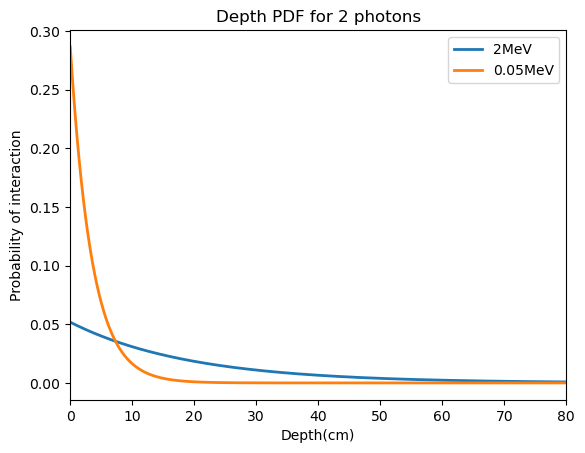

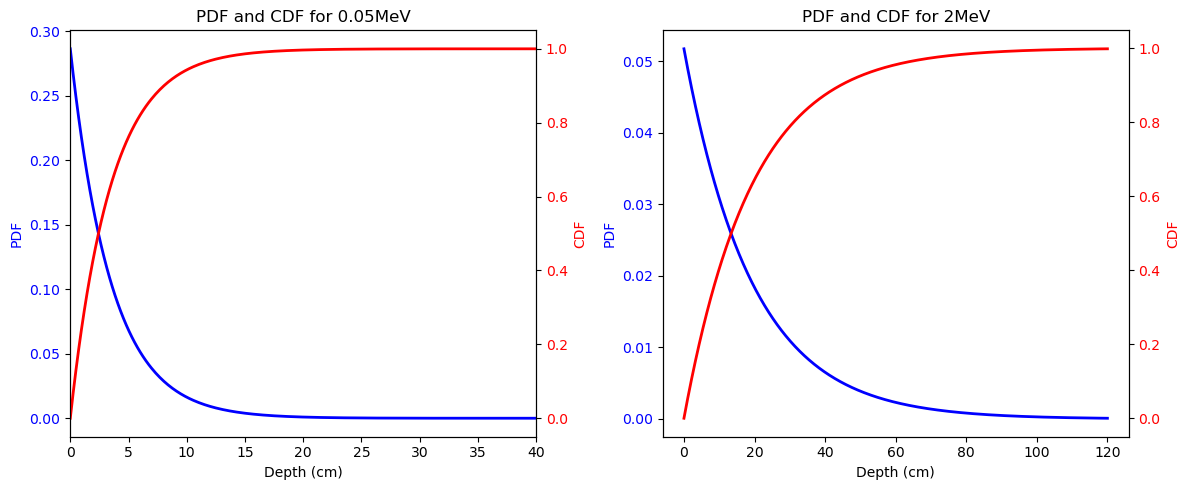

In [185]:
# Generate depth data
d = np.linspace(0,120,1000) # For higher photon energies you might want to incorporate higher depths
# Calculate PDF
P_1 = calculate_PDF(m_1,d)
P_2 = calculate_PDF(m_2,d)
# Calculate CDF
y_1 = calculate_CDF(m_1,d)
y_2 = calculate_CDF(m_2,d)

#Plotting the two PDF's together
fig, ax = plt.subplots()
fig  = ax = plt.plot(d, P_2, lw=2.0, label=f'{photon_energy_2}MeV')
ax = plt.plot(d, P_1, lw=2.0, label=f'{photon_energy_1}MeV')
plt.xlabel('Depth(cm)')
plt.ylabel('Probability of interaction')
plt.title ('Depth PDF for 2 photons')
plt.xlim(0,80)
plt.legend()
plt.show()

# Plotting PDF and CDF for photon energy 1 & photon energy 2
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 5))
# Plotting PDF and CDF for photon energy 1 
ax1.plot(d, P_1, lw=2.0, label='PDF', color='blue')
ax1.set_xlabel('Depth (cm)')
ax1.set_ylabel('PDF', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(d, y_1, lw=2.0, label='CDF', color='red')
ax2.set_ylabel('CDF', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_title(f'PDF and CDF for {photon_energy_1}MeV')
ax1.set_xlim(0,40)
ax2.set_xlim(0,40)
# Plotting PDF and CDF for photon energy 2
ax3.plot(d, P_2, lw=2.0, label='PDF', color='blue')
ax3.set_xlabel('Depth (cm)')
ax3.set_ylabel('PDF', color='blue')
ax3.tick_params(axis='y', labelcolor='blue')
ax4 = ax3.twinx()
ax4.plot(d, y_2, lw=2.0, label='CDF', color='red')
ax4.set_ylabel('CDF', color='red')
ax4.tick_params(axis='y', labelcolor='red')
ax3.set_title(f'PDF and CDF for {photon_energy_2}MeV')
fig.tight_layout()
plt.show()


### Visual Comparison of PDFs and CDFs
Both PDFs for the different energies were plotted together, providing a visual representation of how the probability of interactions changes with increasing energy. As expected, the lower energy photons exhibit a higher probability of interaction at shallower depths, while higher energy photons demonstrate increased penetration, as illustrated by the PDF and CDF.


<a name="4.2"></a>
#  4.2 MC Inverse Transform Method
The inverse function of the Cumulative Distribution Function (CDF), denoted as $T $, was utilised for the inverse transform method. It is given by the analytical expression:
$$
T = -\frac{1}{\mu} \log(1 - x) \, \label{eq8}\tag{8} 
$$
Where $x$  is a random number between 0 and 1.
<br/>
### Visualisation of Sampled Step Lengths
The sampled step lengths were visually represented through histograms. The comparison of Monte Carlo simulated depth distribution with the analytical model indicates a close resemblance, affirming the accuracy of the simulation.


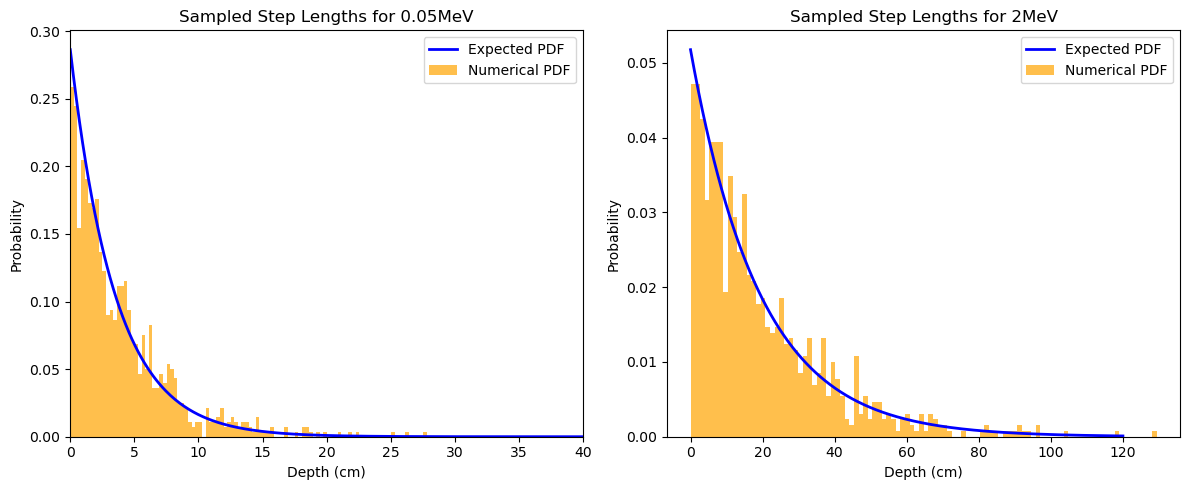

MC Step Length for E = 0.05 MeV is 3.906
Mean Free Path for E = 0.05 MeV is 3.492
MC Step Length for E = 2.00 MeV is 19.296
Mean Free Path for E = 2.00 MeV is 19.321


In [200]:
# expected probability distribution
N = 1000 # Number of photons
def calculate_step_length(m, N):
    t = np.random.uniform(0, 1, N)
    y = (1 / (-m)) * (np.log(1 - t))
    return y

s_1 = calculate_step_length(m_1,N)
s_2 = calculate_step_length(m_2,N)

#Calculating MC Step Lenghts
step_1 = np.mean(s_1)
step_2 = np.mean(s_2)


# Create subplots for PDFs and CDFs
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot for E = photon energy 1 
axs[0].plot(d, P_1, lw=2.0, label='Expected PDF', color='blue')
axs[0].hist(s_1, bins=100, density=True, label='Numerical PDF', alpha=0.7, color='orange')
axs[0].set_xlabel('Depth (cm)')
axs[0].set_xlim(0,40)
axs[0].set_ylabel('Probability')
axs[0].set_title(f'Sampled Step Lengths for {photon_energy_1}MeV')
axs[0].legend()
# Plot for E = photon energy 1 
axs[1].plot(d, P_2, lw=2.0, label='Expected PDF', color='blue')
axs[1].hist(s_2, bins=100, density=True, label='Numerical PDF', alpha=0.7, color='orange')
axs[1].set_xlabel('Depth (cm)')
axs[1].set_ylabel('Probability')
axs[1].set_title(f'Sampled Step Lengths for {photon_energy_2}MeV')
axs[1].legend()
plt.tight_layout()
plt.show()


print("MC Step Length for E = {:.2f} MeV is {:.3f}".format(photon_energy_1, step_1))
print("Mean Free Path for E = {:.2f} MeV is {:.3f}".format(photon_energy_1, 1/m_1))

print("MC Step Length for E = {:.2f} MeV is {:.3f}".format(photon_energy_2, step_2))
print("Mean Free Path for E = {:.2f} MeV is {:.3f}".format(photon_energy_2, 1/m_2))


### Estimation and Comparison of Monte Carlo Step Lengths
Additionally, the Monte Carlo step length was estimated by calculating the mean value of the generated data. This value was then compared to the analytical mean free path of photons, defined as $ \frac{1}{\mu} $.

### Results
For the energies 50KeV and 2MeV:
- Monte Carlo estimated step lengths were 3.438cm and 19.227cm, respectively. (Note: these values will vary each time the simulation is executed.)
- Analytical mean free paths were 3.492cm and 19.321cm, respectively.

The comparison indicates a high degree of accuracy in the Monte Carlo simulation, as the estimated step lengths closely match the analytical expectations. The minimal deviation from the expected values affirms the reliability of the simulation results.


<a name="5"></a>
# 5. Scattered Photon Energy Calculation

In the simulation of photon paths, it is crucial to consider that Compton scattering is the only interaction that does not entirely remove the photon from the beam. During Compton scattering, the photon loses energy, and the relationship between the $$
E = \frac{E_0}{1 + \left(\frac{E_0}{m_0c^2}\right) \cdot \left(1 - \cos(\theta)\right)} \label{eq9}\tag{9}
$$

Where $E_0$ is the initial photon energy, $m_0 c^2$ is the rest energy of the electron, and $\theta$ is the scattering angle.
This formula was utilised to calculate and visualise the energy loss for the two photon energies as a function of angle 


In [170]:
## Function to calculate enegy of scattered photon as a function of scattering angle ##
ang_conv=np.pi/180 #convert to radians
th = np.linspace(0,180,180) #symetrical, only need to simulate up to 2π
th = th*ang_conv

def ens(en,th):
  #f = en/(1+((en/moc2)*(1-np.cos(th))))
  f = 1 + ((en/moc2) * (1 - np.cos(th)))
  return en/f

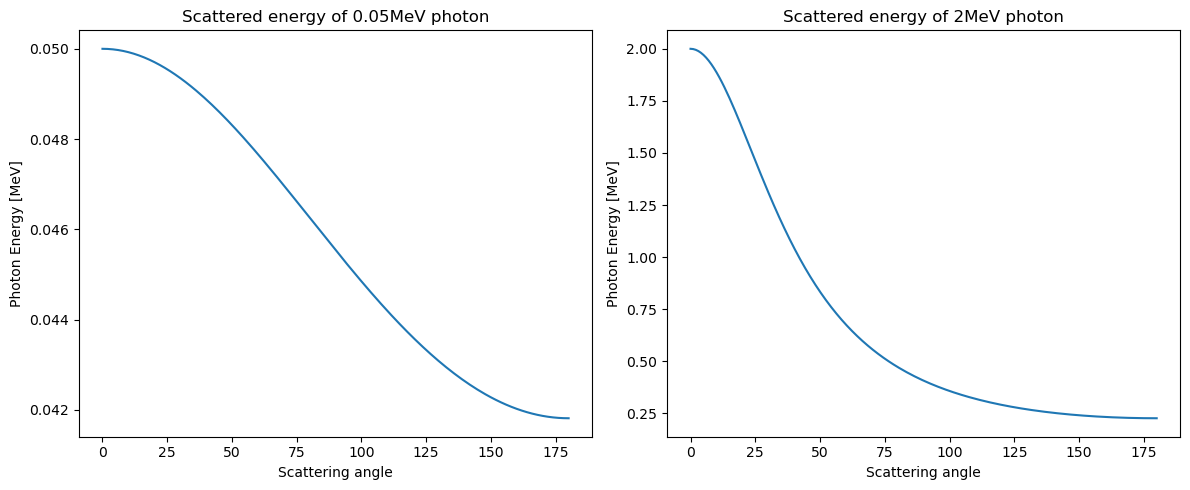

In [171]:
# Create a subplot for both scattered energy plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for E = photon energy 1
axs[0].plot(th / ang_conv, ens(photon_energy_1, th))
axs[0].set_xlabel('Scattering angle')
axs[0].set_ylabel('Photon Energy [MeV]')
axs[0].set_title(f'Scattered energy of {photon_energy_1}MeV photon')


# Plot for E = photon energy 2
axs[1].plot(th / ang_conv, ens(photon_energy_2, th))
axs[1].set_xlabel('Scattering angle')
axs[1].set_ylabel('Photon Energy [MeV]')
axs[1].set_title(f'Scattered energy of {photon_energy_2}MeV photon')
plt.tight_layout()
plt.show()

<a name="6"></a>
# 6. Sampling Compton Scattering Angles

<a name="6.1"></a>
# 6.1 Normalised Differential Cross-section
The differential cross-section for Compton Scattering, denoted as $d\sigma/d\theta$, is expressed as a function of photon energy and scattering angle $𝜃$. The equation is given by:

$$
\frac{d\sigma}{d\theta} = \frac{r_0^2}{2} \left(\frac{h\nu'}{h\nu}\right)^2 \left[\frac{h\nu}{h\nu'} + \frac{h\nu'}{h\nu} - \sin^2(\theta)\right] \sin(\theta) \quad \label{eq10}\tag{10}
$$


This function describes the angular distribution of the scattered photon. Here, $ h\nu$ represents the initial photon energy, $h\nu'$ is the scattered photon energy, and $\theta$ is the scattering angle. The function is normalised based on the numerically obtained maximum value of the differential cross-section. The normalised $\frac{d\sigma}{d\theta}$ as a function of $\theta$ is visually represented for both photon energies.


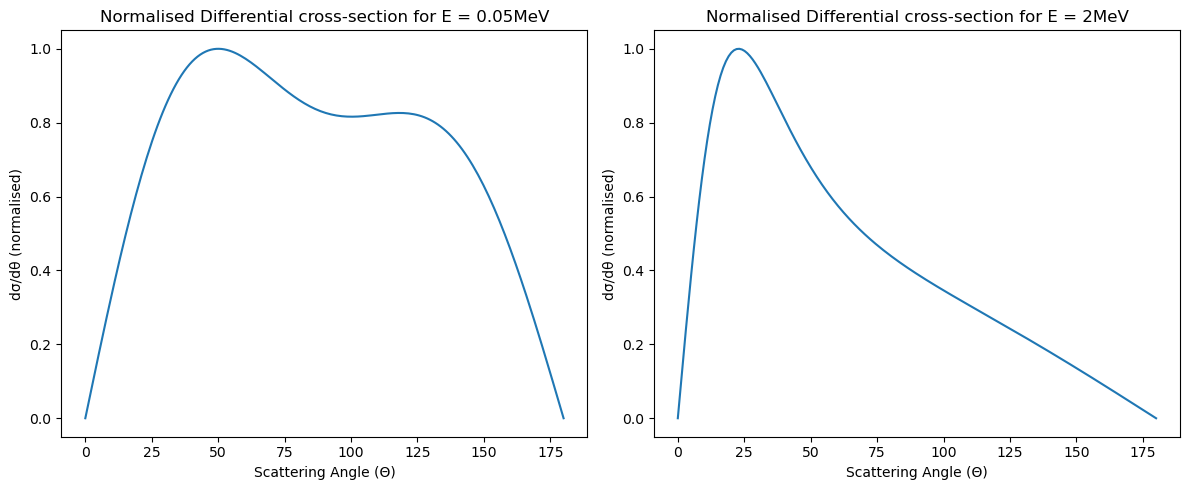

In [172]:
# Simulated scattering angles
th = np.linspace(0,180,180)
th = th*ang_conv # Convert to radians
#Fuction to calculate the normalised differential cross section for compton scattering
def dsdo(en, th):
    enpp = ens(en, th)
    f1 = (enpp / en) ** 2
    f2 = ((enpp / en) + (en / enpp) - (np.sin(th) ** 2)) * np.sin(th)
    f = ((re ** 2) / 2) * f1 * f2
    return f

# Normalising the cross-section
DCS1= dsdo(photon_energy_1 ,th)
DCS2= dsdo(photon_energy_2 ,th)

NDCS1 = DCS1*(1 / max(DCS1))
NDCS2 = DCS2*(1/max(DCS2) )          

# Create a subplot for both normalised differential cross-section plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot for E = photon energy 1
axs[0].plot(th / ang_conv, NDCS1)
axs[0].set_xlabel('Scattering Angle (Θ)')
axs[0].set_ylabel('dσ/dθ (normalised)')
axs[0].set_title(f'Normalised Differential cross-section for E = {photon_energy_1}MeV')

# Plot for E = photon energy 2
axs[1].plot(th / ang_conv, NDCS2)
axs[1].set_xlabel('Scattering Angle (Θ)')
axs[1].set_ylabel('dσ/dθ (normalised)')
axs[1].set_title(f'Normalised Differential cross-section for E = {photon_energy_2}MeV')
plt.tight_layout()
plt.show()


<a name="6.2"></a>
# 6.2 MC Rejection sampling

The rejection technique was employed to sample scattering angles for both photon energies. The normalised differential cross-section $d\sigma/d\theta$, that serves as the probability distribution function (PDF) for the scattering angles, has no well-defined inverse so the accept/reject method had to implemented to simulate scattering angles. In the Monte Carlo simulation, random numbers were generated as inputs for the differential cross-section function, and these values were compared with the actual values of the distribution. If the generated values complied with the distribution, they were accepted; otherwise, they were rejected.


The resulting sampled data were plotted against their respective probability distribution function (PDF) to visually depict the effectiveness of the rejection technique in accurately capturing the expected scattering angles.

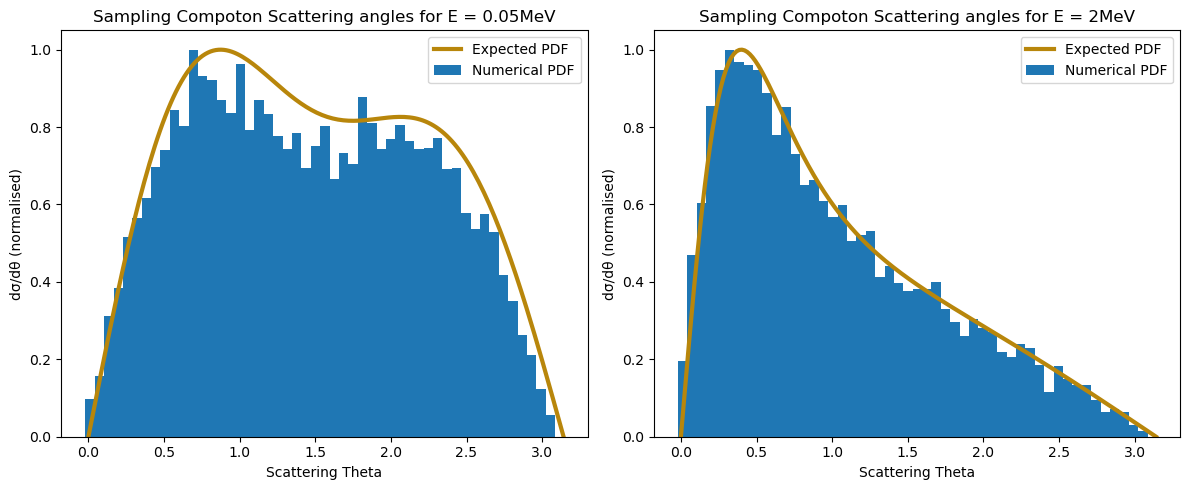

In [187]:
def sampling_scattering_angles(photon_energy, num_photons):
    DCS = dsdo(photon_energy, th)
    NDCS = DCS * (1 / np.max(DCS))

    theta = np.zeros(num_photons)
    scat_max = NDCS.max()

    counter = 0
    while True:
        x = counter
        if counter == num_photons:
            break

        rand_theta = np.random.uniform(0, pi, 1)
        vcsd = dsdo(photon_energy, rand_theta) * (1 / max(DCS))
        rand = np.random.uniform(0, scat_max, 1)

        if rand <= vcsd:
            theta[x] = rand_theta
            counter += 1

    return theta


theta_A = sampling_scattering_angles(photon_energy_1,10**4)
theta_B = sampling_scattering_angles(photon_energy_2,10**4)

# Create a histograms
hist_A, bins = np.histogram(theta_A, bins=50, density=True)
hist_B, bins = np.histogram(theta_B, bins=50, density=True)
# Normalize the histogram values based on frequency
hist_A_normalized = hist_A / np.max(hist_A)
hist_B_normalized = hist_B / np.max(hist_B)


# Plotting Compoton Scattering angles and expected PDF for both photons
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for E = photon energy 1
axs[0].plot(th, NDCS1, lw=3.0, label='Expected PDF', color='darkgoldenrod')
axs[0].bar(bins[:-1], hist_A_normalized, width=bins[1] - bins[0], label='Numerical PDF')
axs[0].set_xlabel('Scattering Theta')
axs[0].set_ylabel('dσ/dθ (normalised)')
axs[0].set_title(f'Sampling Compoton Scattering angles for E = {photon_energy_1}MeV')
axs[0].legend()

# Subplot for E = photon energy 2
axs[1].plot(th, NDCS2, lw=3.0, label='Expected PDF', color='darkgoldenrod')
axs[1].bar(bins[:-1], hist_B_normalized, width=bins[1] - bins[0], label='Numerical PDF')
axs[1].set_xlabel('Scattering Theta')
axs[1].set_ylabel('dσ/dθ (normalised)')
axs[1].set_title(f'Sampling Compoton Scattering angles for E = {photon_energy_2}MeV')
axs[1].legend()
plt.tight_layout()
plt.show()

<a name="7"></a>
# 7. Photon Path Simulation

<a name="7.1"></a>
# 7.1 Frame of Reference Transformation

Utilising Monte Carlo (MC) techniques, we generated photon step-lengths and Compton scattering angles for photons of varying energy. However, the path information is currently represented in the photon frame of reference and not in the laboratory frame of reference.


To address this, the **recurrence transformation** was employed to simulate photon trajectories in water. The functions generated in previous sections were utilised in the code. Additionally, for sampling azimuthal angles, cylindrical symmetry was assumed, and random numbers from a uniform distribution were obtained for the range of $0$ to $2\pi$. The recurrence transformation is defined as the change of reference frame from the photon frame to the lab frame and is defined as:

$$
\cos(\theta_{n+1}) = \sin(\theta_s)\cos(\phi_s)\sin(\theta_n) + \cos(\theta_s)\cos(\theta_n) \quad \label{eq11}\tag{11}
$$

$$
\sin(\phi_{(n+1)} - \phi_n) = \frac{-\sin(\theta_s)\sin(\phi_s)}{\sin(\theta_{(n+1)})} \quad \label{eq12}\tag{12}
$$

This includes updating the scattering and azimuthal angles, as well as the positions in the $x$, $y$, $z$ coordinate system.
Here, the subscript $n$ is used to define the new transformed angles in the lab reference frame, and the subscript $s$ is for the photon reference frame. Utilising the transformed scattered and azimuthal angles, the position of the photon was saved and updated in an \(x, y, z\) coordinate system:

$$
x_{(n+1)} = x_n + \Delta S \sin(\theta_{(n+1)})\cos(\phi_{(n+1)}) \quad \label{eq13}\tag{13}
$$

$$
y_{(n+1)} = y_n + \Delta S \sin(\theta_{(n+1)})\sin(\phi_{(n+1)}) \quad \label{eq14}\tag{14}
$$

$$
z_{(n+1)} = z_n + \Delta S \cos(\theta_{(n+1)}) \quad \label{eq15}\tag{15}
$$


In [174]:
# Recurrence transformation
def rec(th, fi, thn):
    t1 = np.sin(th) * np.cos(fi) * np.sin(thn)
    t2 = np.cos(th) * np.cos(thn)
    t3 = t1 + t2
    t = np.arccos(t3)
    return t

# Azimuthal angle transformation
def azi(th, fi, thn, fi_old):
    g1 = -(np.sin(th) * np.sin(fi))
    g2 = np.sin(thn)
    g3 = g1 / g2
    g4 = np.arcsin(g3)
    g = g4 + fi_old  # Corrected transformation
    return g

# New X-position
def xpos(x, thn, fi):
    xn = x + (Mov * np.sin(thn) * np.cos(fi))
    return float(xn)

# New Y-position
def ypos(y, thn, fi):
    yn = y + (Mov * np.sin(thn) * np.sin(fi))
    return float(yn)

# New Z-position
def zpos(z, thn):
    zn = z + (Mov * np.cos(thn))
    return float(zn)

<a name="7.2"></a>
# 7.2 Simulating Photon Paths in a Water

This code conducts a simulation of photon paths within a medium of water, focusing on their interactions as they traverse through. The simulation utilises all functions discussed above to model various aspects of photon behaviour within the given medium.
<br/>
The simulation initiates with photons entering the system moving towards the positive Z-axis. An initial position of Z=0 is imposed, while the initial X and Y coordinates are randomly chosen within a range of -1 to 1 cm.

### Simulation Parameters
- **Number of Simulated Photons (N):** 1000
- **Cut-off Energy (Ecut):** 0.02 MeV (20 keV)
- **Travel Step Length:** 2cm

### Probability of Interaction
- The attenuation coefficient of photons is calculated at each point, influencing the generation of photon step lengths.
- MC Photon step lengths are used to calculate the probability of interaction at every 2 cm.
- A random number is employed to determine whether photons interact or not.
- If no interaction occurs, the photon depth (Z) increases by 2 cm, while X, Y, and photon energy remain unchanged.

### Interaction Mechanisms
- For interacting photons, the type of interaction is simulated, considering that the photoelectric effect and pair production lead to photon removal from the system.
- Interaction probabilities are estimated based on photon energy.
- A random number is used to determine if Compton scattering occurs. If not, photon energy is set to zero and thus terminating its path.


### Compton Scattering
- If Compton scattering occurs, the simulation identifies the scattering angle.
- MC scattering angles are sampled based on the scattering angle probability distribution.
- A random angle is chosen from the MC data and the photon energy loss is estimated based on the photon initial energy and scattering angle

### Recurrence Transformation
- The simulation utilises the recurrence transformation to update the photon position.
- Scattering angles, azimuthal angles, and step lengths are inputted in the functions depicted above.


### Simulation Loop
- Each photon is simulated until its energy is below the cut-off energy.
- After each interaction, the new X, Y, Z positions, and energy of the photon are calculated and saved.
- If the new energy is greater than the cut-off energy, the simulation continues.

### Simulation Results
- Two sets of simulations are performed with different initial photon energies.
- Photon paths, including X, Y, Z coordinates, and energy, are stored for analysis and comparison.


In [175]:
# Simulation Parameters
N = 1000 # Number of simulated photons
Ecut = 0.02 # Cut-off energy in MeV
Mov = 2  # Travel Step Length - move in intervals of 2cm

# Photon Paths Arrays
x1, y1, z1, E1 = [], [], [], []
x2, y2, z2, E2 = [], [], [], []

for n in range(N):
    x, y, z, E = [], [], [], []
    i = 0
    thn = []
    thn_1 = 0
    fi_old = np.random.uniform(0, 2 * np.pi)
    # Initial position for Z is 0, for X-Y randomised
    xi = np.random.uniform(-1,1)
    yi = np.random.uniform(-1,1)
    x.append(xi)
    y.append(yi)
    z.append(0)
    E.append(photon_energy_1) # Initial Photon Energy
    thn.append(thn_1)
    
    while E[i] > Ecut: # Check if photon energy is higher than the cut-off Energy
        # Probability of interaction
        b_1 = total_attenuation_coefficient(E[i])
        m = b_1[0] # Calculate photon attenuation
        sl = calculate_step_length(m, 100) # Sample Step-Lenghts
        Prob = random.choice(sl)
        a = np.random.uniform(0, Mov) # Determine if photon interacts
        if a < Prob:
            z.append(z[i] + Mov) # Photon moves only in Z if it doesn't interact
            x.append(x[i])
            y.append(y[i])
            E.append(E[i])
            thn.append(thn[i])

        else:
            int_prob = calculate_interaction_probabilities(E[i]) # Calculate interaction probabilities
            cm_prob = int_prob[1] # Probability of Compton Scattering
            p = np.random.uniform(0, 1)
            if p > cm_prob: # Determine if photon interacts with Compton scattering
                # If not, photon is removed from the system and energy set to 0
                E[i] = 0 
                z.append(z[i])
                x.append(x[i])
                y.append(y[i])
                E.append(E[i])
            else:
                theta = sampling_scattering_angles(E[i],100) # Generate MC scattering angle sample data based on photon energy
                th_photon = random.choice(theta)  # Random scattering angle based on MC Sampled Data
                fi_photon = np.random.uniform(0, 2 * np.pi, 1)  # Cylindrical symmetry, so uniform probability.
                E.append(ens(E[i], random_num)) # Calculate  photon energy after interaction
                # Perform recurrence transformation
                thn_old = thn[i]
                thn_new = rec(th_photon, fi_photon, thn_old) # Calculate new thn
                thn.append(thn_new) # Update thn_old
                fi_new = azi(th_photon, fi_photon, thn_new, fi_old) # Calculate new fi
                fi_old = fi_new  # Update fi_old
                # Calculate positions
                x.append(xpos(x[i], thn_new, fi_new))
                y.append(ypos(y[i], thn_new, fi_new))
                z.append(zpos(z[i], thn_new))
        i += 1
    x1.append(x)
    y1.append(y)
    z1.append(z)
    E1.append(E)
    
    
## Simulate 2MeV photon paths ##    
for n in range(N):
    x, y, z, E = [], [], [], []
    i = 0
    thn = []
    fi_old = np.random.uniform(0, 2 * np.pi)  # Initialise fi_old
    # Initial position for Z is 0, for X-Y randomised
    xi = np.random.uniform(-1,1)
    yi = np.random.uniform(-1,1)
    x.append(xi)
    y.append(yi)
    z.append(0)
    thn.append(thn_1)
    E.append(photon_energy_2) # Initial Photon Energy


    while E[i] > Ecut: # Check if photon energy is higher than the cut-off Energy
        # Probability of interaction
        b_1 = total_attenuation_coefficient(E[i])
        m = b_1[0] # Calculate photon attenuation
        sl = calculate_step_length(m,100) # Sample Step-Lenghts
        Prob = random.choice(sl)
        a = np.random.uniform(0, Mov) # Determine if photon interacts
        if a < Prob:
            z.append(z[i] + Mov)# Photon moves only in Z if it doesn't interact
            x.append(x[i])
            y.append(y[i])
            E.append(E[i])
            thn.append(thn[i])

        else:
            int_prob = calculate_interaction_probabilities(E[i]) # Calculate interaction probabilities
            cm_prob = int_prob[1] # Probability of Compton Scattering
            p = np.random.uniform(0, 1)
            if p > cm_prob: # Determine if photon interacts with Compton scattering
                # If not, photon is removed from the system and energy is thus 0
                E[i] = 0 
                z.append(z[i])
                x.append(x[i])
                y.append(y[i])
                E.append(E[i])
            else:
                theta = sampling_scattering_angles(E[i],100) # Generate MC scattering angle sample data based on photon energy
                th_photon = random.choice(theta)  # Random scattering angle based on MC Sampled Data
                fi_photon = np.random.uniform(0, 2 * np.pi, 1)  # Cylindrical symmetry, so uniform probability.
                E.append(ens(E[i], random_num)) # Calculate  photon energy after interaction
                # Perform recurrence transformation
                thn_old = thn[i]
                thn_new = rec(th_photon, fi_photon, thn_old) # Calculate new thn
                thn.append(thn_new) # Update thn_old
                fi_new = azi(th_photon, fi_photon, thn_new, fi_old) # Calculate new fi
                fi_old = fi_new  # Update fi_old
                # Calculate positions
                x.append(xpos(x[i], thn_new, fi_new))
                y.append(ypos(y[i], thn_new, fi_new))
                z.append(zpos(z[i], thn_new))
        i += 1
    x2.append(x)
    y2.append(y)
    z2.append(z)
    E2.append(E)

<a name="8"></a>
# 8. Conclusion and Visualisations


In this specialised section focused on visualisation, we journey into the fascinating realm of photon beam trajectories, offering a detailed view of their activity across different energy ranges. This visual investigation is a key element of these larger simulation, revealing the intricate interplay of photons as they traverse the medium.
<br/>
The photon trajectories for 1000 photons of energy 50KeV and 2MeV planar graphs of the x-z, y-z and x-y planes are presented.


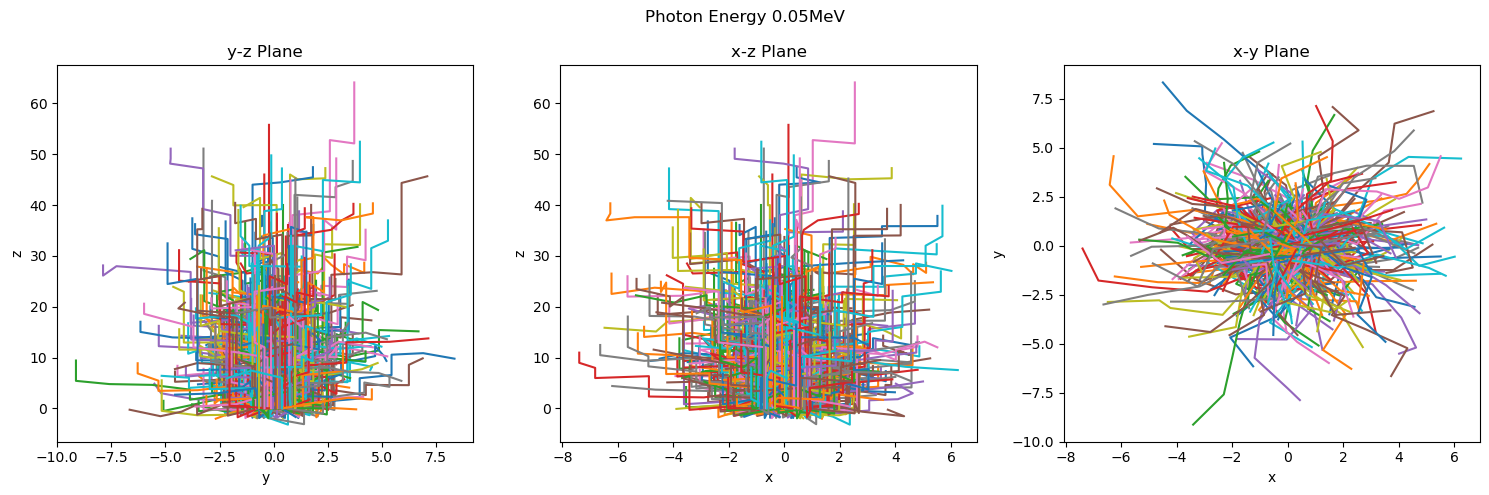

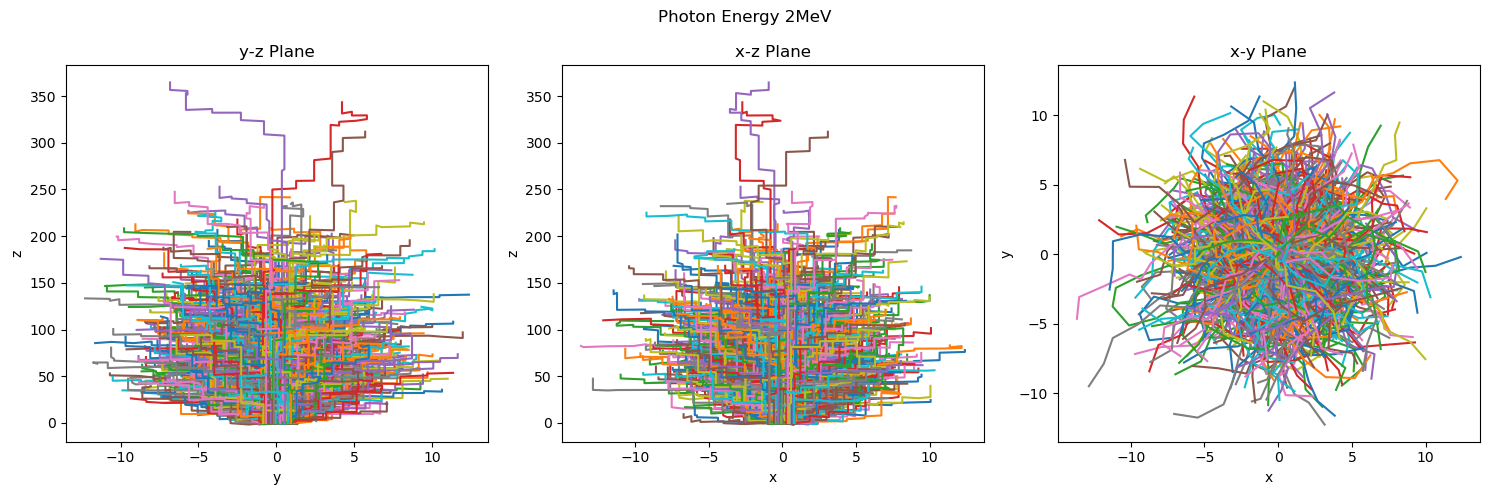

In [176]:
# Plotting
## Photon Energy 1
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
for n in range(N):
    axs[0].plot(y1[n], z1[n])
axs[0].set_xlabel('y')
axs[0].set_ylabel('z')
axs[0].set_title('y-z Plane')
for n in range(N):
    axs[1].plot(x1[n], z1[n])

axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
axs[1].set_title('x-z Plane')

for n in range(N):
    axs[2].plot(x1[n], y1[n])
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('x-y Plane')
fig.suptitle(f'Photon Energy {photon_energy_1}MeV')
plt.tight_layout()
plt.show()

## Photon Energy 2
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
for n in range(N):
    axs[0].plot(y2[n], z2[n])
axs[0].set_xlabel('y')
axs[0].set_ylabel('z')
axs[0].set_title('y-z Plane')

for n in range(N):
    axs[1].plot(x2[n], z2[n])
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
axs[1].set_title('x-z Plane')

for n in range(N):
    axs[2].plot(x2[n], y2[n])
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('x-y Plane')
fig.suptitle(f'Photon Energy {photon_energy_2}MeV')
plt.tight_layout()
plt.show()


<a name="8.1"></a>
## 8.1 High vs. Low-Energy Photon Paths
**High-Energy Interactions:**
<br/>
High-energy photons show strong penetration and a tendency for forward scatter. Their path is straightforward and robust.


**Low-Energy Interactions:**
<br/>
Conversely, lower energy photons exhibit complex interactions, leading to scattered paths. This reveals the unpredictable nature of their movement.

**Backscatter Differences: 50 keV vs. 2 MeV**
<br/>
A notable finding is the difference in backscatter between 50 keV and 2 MeV photons. The 50 keV photons show more pronounced backscatter compared to their higher-energy counterparts. This aligns with theoretical expectations based on the differential cross-sections.


<a name="8.2"></a>
## 8.2 Visual Representation: Energy Contrast
The visual representation features red trajectories for high-energy photons and blue for low-energy ones. This stark contrast aids in quickly grasping the differing paths.


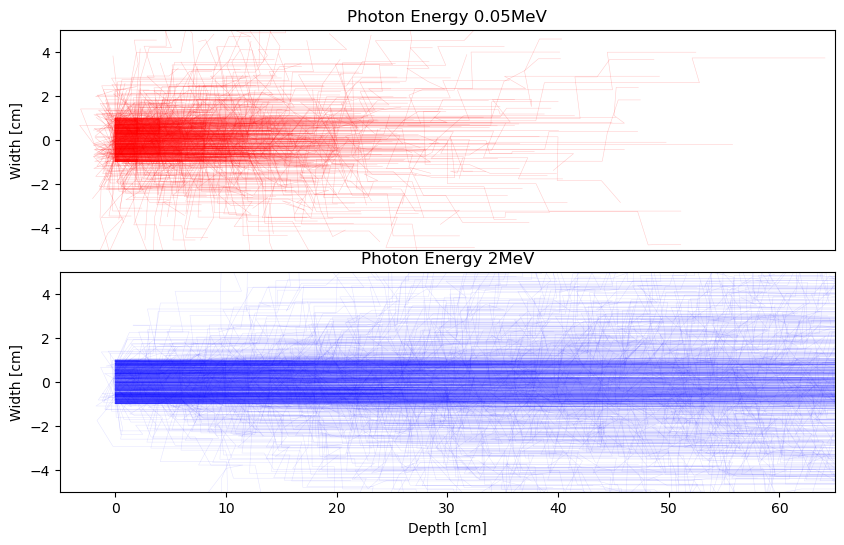

In [182]:

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=False)  # 2 rows, 1 column, share x-axis

# Plot z-x plane for energy 1
for n in range(N):
    axs[0].plot(z1[n], y1[n], 'r-', linewidth=0.4, alpha=0.2)
axs[0].set_ylabel('Width [cm]')
axs[0].set_title(f'Photon Energy {photon_energy_1}MeV')
axs[0].set_xlim([-5, 65])  
axs[0].set_ylim([-5, 5])  

# Plot z-x plane for energy 2
for n in range(N):
    axs[1].plot(z2[n], y2[n], 'b-', linewidth=0.4, alpha=0.1)  # Assuming z2 and x2 are defined for energy 2
axs[1].set_xlabel('Depth [cm]')
axs[1].set_ylabel('Width [cm]')
axs[1].set_title(f'Photon Energy {photon_energy_2}MeV')
axs[1].set_xlim([-5, 65])  
axs[1].set_ylim([-5, 5])  
# Remove x-axis from the top subplot
axs[0].tick_params(axis='x', which='both', bottom=False, top=False)
plt.subplots_adjust(hspace=0.1)
plt.show()


In essence, this straightforward trajectory analysis contributes crucial insights, shedding light on energy-dependent photon behaviors within our physics simulation.

<a name="8.3"></a>
## 8.3 Evolution of 2 MeV Photons: Attenuation and Scattering

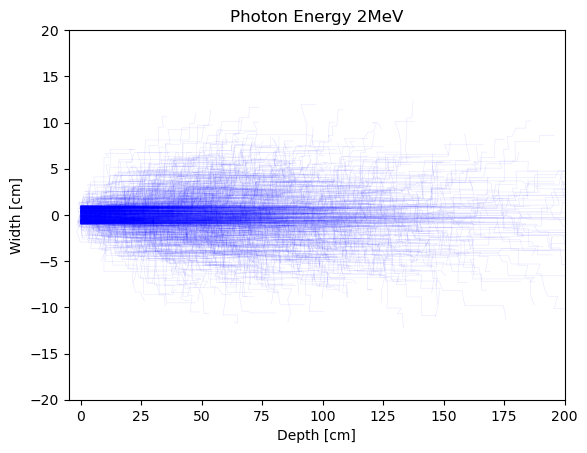

In [178]:
for n in range(N):
    plt.plot(z2[n], y2[n], 'b-', linewidth=0.4, alpha=0.1)  # Assuming z2 and x2 are defined for energy 2
plt.xlabel('Depth [cm]')
plt.ylabel('Width [cm]')
plt.xlim([-5, 200])  
plt.ylim([-20, 20])  
plt.title(f'Photon Energy {photon_energy_2}MeV')
plt.show()

Analysing the 2 MeV photon beams reveals an interesting evolution. Despite starting strong, high-energy photons undergo attenuation and exhibit scattering similar to lower-energy photons at greater depths. As the beam traverses through the medium, photons interact via Compton scattering and loose energy and thus experience a more uniform scattering in subsequent interactions.